# Cultural Change Among r/lgbt Subreddit Users, 2008-2018
### Dynamic Topic Modeling using BERTopic

**Author**: Devon Rojas<br>
**Date**: 12/15/24

In [1]:
import pandas as pd
import numpy as np
import json, os, glob, re
from datetime import datetime
import random
from tqdm.notebook import tqdm

import util
from bertopic import BERTopic

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_FILE = "lgbt.csv"

### Read in data file and transform into necessary format for model analyses

In [3]:
df = util.read_data(DATA_FILE)

/Volumes/Academic/Classes/STAT236/code/util.py:14: DtypeWarning: Columns (0,2,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dir, index_col=0)


In [4]:
df.head()

,title,num_comments,domain,timestamp,subreddit,gilded,gildings,stickied,author_flair_text,root,text,ym,type,combined,length,year
0,Bootblacking: Not Just for the Boys,0,carnalnation.com,2010-07-01 00:26:04,lgbt,0.0,NaN,False,NaN,ckqsn,NaN,2010-07,lgbtq,Bootblacking: Not Just for the Boys,35,2010.0
1,Why gay marriage is good for everyone.,0,scienceblogs.com,2010-07-01 00:28:59,lgbt,0.0,NaN,False,NaN,ckqto,NaN,2010-07,lgbtq,Why gay marriage is good for everyone.,38,2010.0
2,Lady Gaga doing Drag for Vogue Hommes Japan. I...,7,community.livejournal.com,2010-07-01 01:14:41,lgbt,0.0,NaN,False,NaN,ckr8y,"But I mean.. she is a man, right?\n\nShe makes...",2010-07,lgbtq,Lady Gaga doing Drag for Vogue Hommes Japan. I...,336,2010.0
3,LGBT Youth Face High Rates of Homelessness and...,0,thecurvature.com,2010-07-01 02:17:45,lgbt,0.0,NaN,False,NaN,ckrtf,NaN,2010-07,lgbtq,LGBT Youth Face High Rates of Homelessness and...,60,2010.0
4,Google to Add Pay to Cover a Tax for Same-Sex ...,1,nytimes.com,2010-07-01 03:11:52,lgbt,0.0,NaN,False,NaN,cksbd,[Fantastic.](http://imgur.com/MJI2D.gif),2010-07,lgbtq,Google to Add Pay to Cover a Tax for Same-Sex ...,110,2010.0


In [30]:
# df['percentile'] = df['length'].rank(method="average", pct=True) * 100

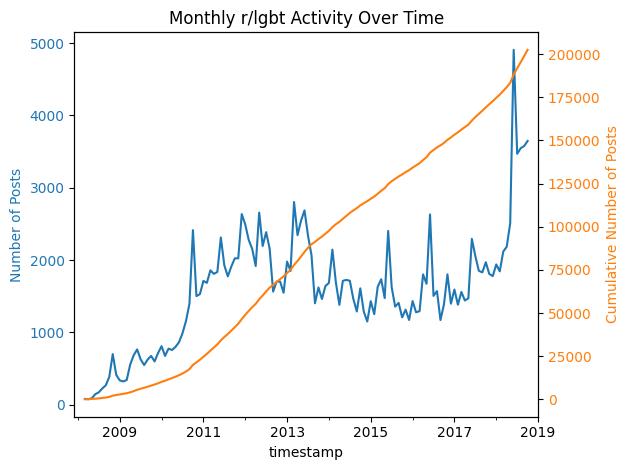

In [120]:
fig, ax = plt.subplots()

freqs = df.groupby(df['timestamp'].dt.to_period("M"))['timestamp'].count()
freqs = freqs.reset_index(name="count")
freqs['cumsum'] = freqs['count'].cumsum()

freqs.plot.line(x="timestamp", y="count", ax = ax, color="tab:blue")
ax.set_title("Monthly r/lgbt Activity Over Time")
ax.set_ylabel("Number of Posts", color="tab:blue")
ax.tick_params(axis="y", labelcolor="tab:blue")
ax.get_legend().remove()

ax2 = ax.twinx()
freqs.plot.line(x="timestamp", y="cumsum", ax = ax2, color="tab:orange")
ax2.set_ylabel("Cumulative Number of Posts", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")
ax2.get_legend().remove()

ax2.set_xlim(pd.to_datetime("2007-12-31"), pd.to_datetime("2019-01-01"))
fig.tight_layout()
fig.savefig("figures_tables/post_freqs.png")

In [5]:
texts = df['combined'].to_list()
dates = df['timestamp'].to_list()

### Specify desired model to perform below analyses on.

In [ ]:
model = BERTopic.load("lgbt_bertopic_unigram_v4_no_reduce.pickle")

### Initial Topic Labeling

I output the keyword representations for each topic into a csv file to do a first pass on labeling the topics.

In [32]:
topic_df = model.get_topic_info()
topic_df["Representation"] = topic_df["Representation"].apply(lambda x: "\n".join(x))
topic_df["KeyBERT"] = topic_df["KeyBERT"].apply(lambda x: "\n".join(x))
topic_df["MMR"] = topic_df["MMR"].apply(lambda x: "\n".join(x))
topic_df[['Topic', 'Name', 'Representation', 'KeyBERT', 'MMR']].to_csv("UnlabeledTopics.csv", index=False)

Once the labeling is done, we can read them back in and append them to the topic model

In [61]:
labeled_topics = pd.read_csv("LabeledTopics.csv")
labeled_topics = labeled_topics[["Topic", "Initial Label"]]
labeled_topics['label'] = labeled_topics["Topic"].astype(str) + "_" + labeled_topics["Initial Label"]
labeled_topics.head()

,Topic,Initial Label,label
0,-1,Outlier,-1_Outlier
1,0,Coming out to Family and Friends,0_Coming out to Family and Friends
2,1,Appearance,1_Appearance
3,2,Relationship Advice,2_Relationship Advice
4,3,Music,3_Music


During this step, I also identify the list of topics that are most relevant to this project, seen below.

In [76]:
topics_of_interest = [
    *range(0,11),
    21, 24, 30, 46, 47, 48, 50,
    52, 54, 56, 57, 60, 64, 66, 
    68, 74, 83, 88, 89, 90, 108, 
    129, 160, 163, 172, 181, 185, 
    193, 198, 200, 203
]

In [63]:
model.set_topic_labels(labeled_topics["label"].to_list())
topic_df = model.get_topic_info()

In [ ]:
# with open("topics_of_interest.tex", "w") as f:
#     f.write(labeled_topics[labeled_topics["Topic"].isin(topics_of_interest)][["Topic", "Initial Label"]].to_latex(index=False, escape=False))

In [ ]:
topics_and_terms = topic_df[['Topic', 'CustomName', "Representation"]]
topics_and_terms['Representation'] = topics_and_terms["Representation"].apply(lambda s: ", ".join(s[:5]))
# topics_and_terms = topics_and_terms[topics_and_terms["Topic"].isin(topics_of_interest)]
topics_and_terms["CustomName"] = topics_and_terms["CustomName"].apply(lambda s: re.sub("^-?\\d*_", "", s))
topics_and_terms

,Topic,CustomName,Representation
0,-1,Outlier,"people, like, just, gay, im"
1,0,Coming out to Family and Friends,"parents, family, mom, come, friends"
2,1,Appearance,"look, beautiful, congrats, congratulations, cute"
3,2,Relationship Advice,"friend, hes, guy, relationship, friends"
4,3,Music,"song, music, video, songs, macklemore"
...,...,...,...
203,202,Polygamy,"polygamy, marriage, polygamous, marriages, legal"
204,203,Body Standards,"fat, weight, overweight, body, guys"
205,204,Texas Same-Sex Policies,"texas, austin, anal, texan, texans"
206,205,Salvation Army,"salvation, army, sa, charity, organization"


In [ ]:
# with open("all_topics.tex", "w") as f:
#     f.write(topics_and_terms.to_latex(index=False, escape=False))

Because the default function implementation only returns the top 3 representative documents for each topic, we can utilize an internal function to get more representative docs.

In [52]:
doc_topic = pd.DataFrame({
  'Topic':model.topics_,
  'ID':range(len(model.topics_)),
  'Document':texts}
)
repr_docs, _, ord_doc_indxs, doc_idxs =  model._extract_representative_docs(
    model.c_tf_idf_, 
    doc_topic,
    model.topic_representations_,
    nr_samples=1000,
    nr_repr_docs=10 ## Set the number of representative docs desired here
)
model.representative_docs_ = repr_docs

Once we've increased the number of representative documents we get for each topic, we can use them to get a better sense of what each topic theme is. This can be combined with the key word representations for each topic, which we can create below:

In [ ]:
import textwrap
topic_num = 1 # Change this value to print out representative documents from different topics
doc_length = 100 # Adjust value here to print out more of each representative document
docs = model.get_representative_docs(topic_num)
for idx, doc in enumerate(docs):
    print(f"DOCUMENT {idx+1}")
    print("\n".join(textwrap.wrap(doc[:doc_length], replace_whitespace=False, width=150)))
    print()

DOCUMENT 1
65 days ago I posted how I was getting married. Yesterday I done it!

This looks amazing! Congratula

DOCUMENT 2
Half a year on hormones already today?!! These pics were taken exactly 1 year apart. OMG lol. I thin

DOCUMENT 3
I changed a lot over the past year...

Looking good! Congratulations!

YAY!!!  &lt;3

congrats! you

DOCUMENT 4
Two years ago today I took my first estrogen pill :)

You look fabulous honey! 💖

You look great! Be

DOCUMENT 5
15 months on hormones and finally living my life

Cute

Thankyou 😊

No problem. Very cute. Glad you’

DOCUMENT 6
One year on Hormones toady!(MtF) What an incredible year!

you're looking damn good

I like the hair

DOCUMENT 7
I finally consider my transition mostly complete:) Hi, i'm Ava!

Very lovely

Proud of you, Ava! ❤️

DOCUMENT 8
Yesterday I married my best friend. (I’m on the right)

Congratulations from South Korea &lt;3

Cong

DOCUMENT 9
18 Months into transition MTF. Starting to feel really good about myself.

You look inc

In [ ]:
# with open("topics_of_interest.tex", "w") as f:
#     f.write(topics_and_terms.to_latex(index=False, escape=False))

### Perform Dynamic Topic Modeling

Tune topic model to desired time intervals. Here I'm passing in the full timestamp data as ```dates``` but I am restricted the total number of intervals to 50 to prevent overfitting.

In [68]:
topics_over_time = model.topics_over_time(texts, dates, nr_bins=25, global_tuning=False)

25it [00:25,  1.02s/it]


Once the tuning is completed, we can visualize the trends for different topics over the time intervals.

In [71]:
model.visualize_topics_over_time(topics_over_time, topics=topics_of_interest, custom_labels=True)

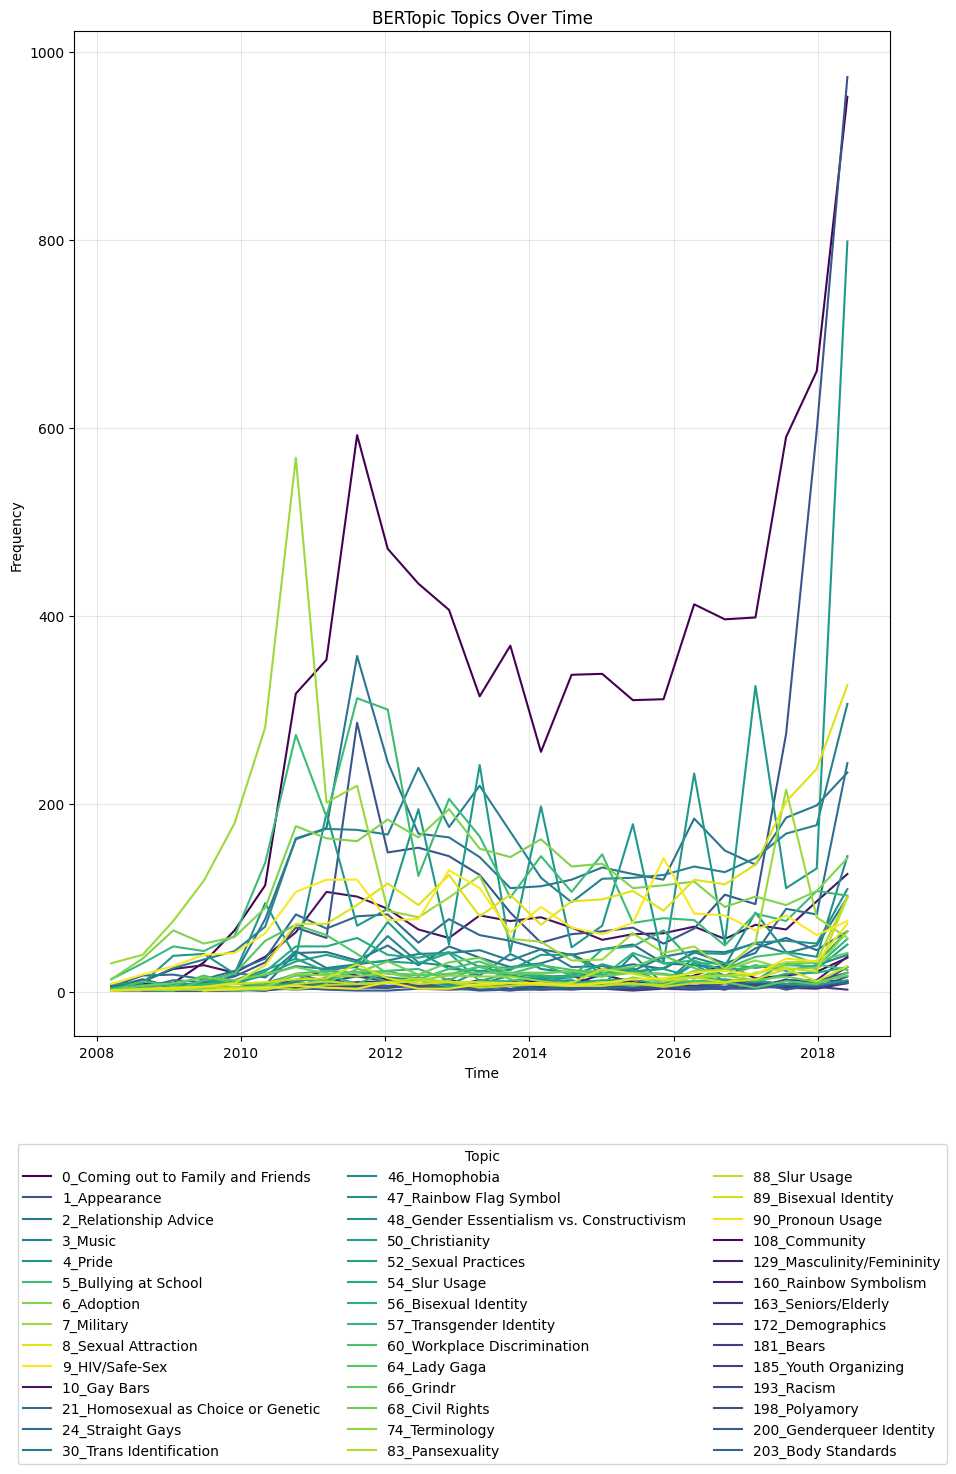

In [118]:
import matplotlib.pyplot as plt

# NOTE: Must run line above to get labels in data frame
TOT_groups = topics_over_time[topics_over_time['Topic'].isin(topics_of_interest)].sort_values(["Topic", "Timestamp"]).groupby("Name")
plt.figure(figsize=(10, 15))
for name, group in list(TOT_groups):
    plt.plot(group["Timestamp"], group["Frequency"], label=name)


plt.title("BERTopic Topics Over Time")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.xlim(right=pd.to_datetime("2019-01-01"))

handles, labels = plt.gca().get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), 
                              key=lambda t: int(re.sub("^(-?\\d*)(.*)", "\\g<1>", t[0]))))

plt.legend(handles, labels, title="Topic", bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout(rect=(0, 0, 1, 1))
# plt.savefig("top_topics_over_time.png")

We can also get how the top words for each topic change at each time interval.

In [36]:
words_over_time = topics_over_time[topics_over_time["Topic"]==21].sort_values(["Topic", "Timestamp"])
words_over_time['Words'] = words_over_time['Words'].apply(lambda s: s.split(","))
words_over_time = words_over_time.explode("Words")
words_over_time["Pos"] = words_over_time.groupby("Timestamp").cumcount()+1
words_over_time["Time_Pos"] = words_over_time.groupby("Timestamp").ngroup()+1
words_over_time = words_over_time.pivot(columns="Pos", index=["Time_Pos"], values="Words")
words_over_time

Pos,1,2,3,4,5
Time_Pos,,,,,
1,fetus,theory,womb,affect,dna
2,choice,choose,lifestyle,stewart,miscegenation
3,choice,homosexuality,gene,genes,choices
4,trait,bearded,horses,evolution,fondling
5,gene,genes,choice,genetic,studies
6,choice,gene,choose,ketchup,defect
7,choice,homosexuality,choose,genetic,gene
8,choice,homosexuality,choose,genetic,argument
9,choice,choose,homosexuality,genetic,cain


In [ ]:
# with open("homosexual_choice.tex", "w") as f:
#     f.write(words_over_time.to_latex())